# EKE

**GOAL:**  
The code evaluates and ranks multiple model configurations based on their **SST** and **SSS RMSE within eddy-active regions**, where eddies are defined by an **EKE threshold**. It applies an eddy mask, computes RMSEs against observations, and prints rankings to identify the best-performing configurations in those regions.


---

## Imports

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Data

In [2]:
model = xr.open_dataset("../../data/processed/model.nc")
model

<xarray.Dataset> Size: 9MB
Dimensions:  (month: 12, lat: 180, lon: 360)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    sst      (month, lat, lon) float32 3MB ...
    sss      (month, lat, lon) float32 3MB ...
    mld      (month, lat, lon) float32 3MB ...
Attributes:
    regrid_method:  bilinear

In [3]:
obs = xr.open_dataset("../../data/processed/combined_observations.nc")
obs

<xarray.Dataset> Size: 9MB
Dimensions:  (month: 12, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    sst      (month, lat, lon) float32 3MB ...
    sss      (month, lat, lon) float32 3MB ...
    mld      (month, lat, lon) float32 3MB ...

In [4]:
eke = xr.open_dataset("../../data/obs/dt_global_twosat_phy_l4_202307_vDT2021-M01.nc")
eke

<xarray.Dataset> Size: 17MB
Dimensions:           (time: 1, nv: 2, latitude: 720, longitude: 1440)
Coordinates:
  * time              (time) datetime64[ns] 8B 2023-07-15
  * latitude          (latitude) float32 3kB -89.88 -89.62 ... 89.62 89.88
  * longitude         (longitude) float32 6kB 0.125 0.375 0.625 ... 359.6 359.9
  * nv                (nv) int32 8B 0 1
Data variables:
    crs               int32 4B ...
    climatology_bnds  (time, nv) datetime64[ns] 16B ...
    lat_bnds          (latitude, nv) float32 6kB ...
    lon_bnds          (longitude, nv) float32 12kB ...
    sla               (time, latitude, longitude) float64 8MB ...
    eke               (time, latitude, longitude) float64 8MB ...
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Monthly Mean of Sea Level Anomalies refe...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         Delayed Time Level-4 monthly means of Se...
    time_coverage_duration:          P1M
    time_coverage_end:               2023-07-31T00:00:00Z
    time_coverage_resolution:        P1M
    time_coverage_start:             2023-07-01T00:00:00Z
    title:                           DT merged two-satellite Global Ocean L4 ...

In [5]:
# Define target regular grid (1° resolution)
target_lat = np.linspace(-89.5, 89.5, 180)   # 180 latitudes from -89.5° to 89.5°
target_lon = np.linspace(0.5, 359.5, 360)    # 360 longitudes from 0.5° to 359.5°

# Interpolate EKE data to the target grid using nearest-neighbor method
eke = eke.sel(
    latitude=target_lat,
    longitude=target_lon,
    method="nearest"
).assign_coords(
    latitude=target_lat,
    longitude=target_lon
).rename(
    {'latitude': 'lat', 'longitude': 'lon'}
)["eke"]  # Extract the "eke" variable from the dataset

eke  # Show the interpolated DataArray

<xarray.DataArray 'eke' (time: 1, lat: 180, lon: 360)> Size: 518kB
[64800 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-07-15
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    cell_methods:   time: mean within years
    grid_mapping:   crs
    long_name:      Averaged Eddy Kinetic Energy 2023/07
    standard_name:  specific_kinetic_energy_of_sea_water
    units:          cm2/s2

## Eddy errors

Results for EKE threshold: 2500


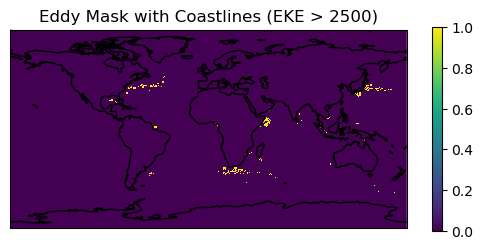

----------------------------------------
Ranking for SST (eddy regions, EKE > 2500):
1. Config 14: RMSE = 1.448
2. Config 04: RMSE = 1.452
3. Config 17: RMSE = 1.457
4. Config 00: RMSE = 1.457
5. Config 16: RMSE = 1.457
6. Config 05: RMSE = 1.460
7. Config 15: RMSE = 1.494
8. Config 07: RMSE = 1.512
9. Config 06: RMSE = 1.518
10. Config 12: RMSE = 1.529
11. Config 08: RMSE = 1.538
12. Config 10: RMSE = 1.544
13. Config 01: RMSE = 1.578
14. Config 09: RMSE = 1.587
15. Config 02: RMSE = 1.765
----------------------------------------
----------------------------------------
Ranking for SSS (eddy regions, EKE > 2500):
1. Config 08: RMSE = 2.222
2. Config 09: RMSE = 2.256
3. Config 02: RMSE = 2.266
4. Config 10: RMSE = 2.282
5. Config 06: RMSE = 2.288
6. Config 07: RMSE = 2.291
7. Config 12: RMSE = 2.294
8. Config 15: RMSE = 2.304
9. Config 01: RMSE = 2.308
10. Config 17: RMSE = 2.320
11. Config 00: RMSE = 2.322
12. Config 16: RMSE = 2.322
13. Config 14: RMSE = 2.364
14. Config 05: RMSE = 2

In [6]:
# List of configuration identifiers to process
cfgs = ["00", "01", "02", "04", "05", "06", "07", "08", "09", "10", "12", "14", "15", "16", "17"]

# EKE threshold used to define eddy-active regions
eke_thr = 2500

# Print header with threshold information
print("="*60)
print(f"Results for EKE threshold: {eke_thr}")
print("="*60)

# Step 1: Create boolean mask identifying eddy regions (EKE above threshold)
eddy_mask = eke > eke_thr

# Step 2: Plot the eddy mask over a map projection
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
im = eddy_mask.plot(ax=ax, transform=proj, cmap='viridis', add_colorbar=False)
ax.coastlines()
plt.colorbar(im, ax=ax, shrink=0.55)
plt.title(f"Eddy Mask with Coastlines (EKE > {eke_thr})")
plt.show()

# Step 3: Compute RMSE of SST and SSS within eddy regions for each configuration
rmse_results = { "sst": [], "sss": [] }

for cfg in cfgs:
    # Load model output for current configuration
    ds = xr.open_dataset(f"../../data/processed/nemo{cfg}.nc")

    for var in ["sst", "sss"]:
        # Compute squared error and mask to eddy regions
        error = ds[var] - obs[var]
        rmse_eddy = np.sqrt((error.where(eddy_mask)**2).mean())

        # Store RMSE along with configuration label
        rmse_results[var].append((cfg, float(rmse_eddy.values)))

    ds.close()

# Step 4: Print configurations ranked by RMSE (ascending) for each variable
for var in ["sst", "sss"]:
    print("-"*40)
    print(f"Ranking for {var.upper()} (eddy regions, EKE > {eke_thr}):")
    ranked = sorted(rmse_results[var], key=lambda x: x[1])
    for i, (cfg, rmse) in enumerate(ranked, 1):
        print(f"{i}. Config {cfg}: RMSE = {rmse:.3f}")
    print("-"*40)